## Collaborative Filtering

In [1]:
# load the libraries and data
from fastai.collab import *
from fastai.tabular.all import *

In [2]:
path = untar_data(URLs.ML_100k)

In [3]:
path.ls()

(#23) [Path('/storage/data/ml-100k/ua.base'),Path('/storage/data/ml-100k/README'),Path('/storage/data/ml-100k/u4.test'),Path('/storage/data/ml-100k/u.genre'),Path('/storage/data/ml-100k/u.item'),Path('/storage/data/ml-100k/u2.test'),Path('/storage/data/ml-100k/u.user'),Path('/storage/data/ml-100k/u5.test'),Path('/storage/data/ml-100k/u.occupation'),Path('/storage/data/ml-100k/u5.base')...]

In [4]:
# read the ratings 
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                     names=['user', 'movie', 'rating', 'timestamp'])
ratings.head()

,user,movie,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [5]:
# assume three latent factors of two movies
casablanca = np.array([.98, .9, -.9])
titanic = np.array([.4, -.3, .9])

In [6]:
# and assume a user with latent factors
user1 = np.array([.8, .95, -.4])

In [7]:
# then this could be a cost of
(user1 * casablanca).sum(), (user1 * titanic).sum()

(1.999, -0.32499999999999996)

### Learning the Latent Factors 

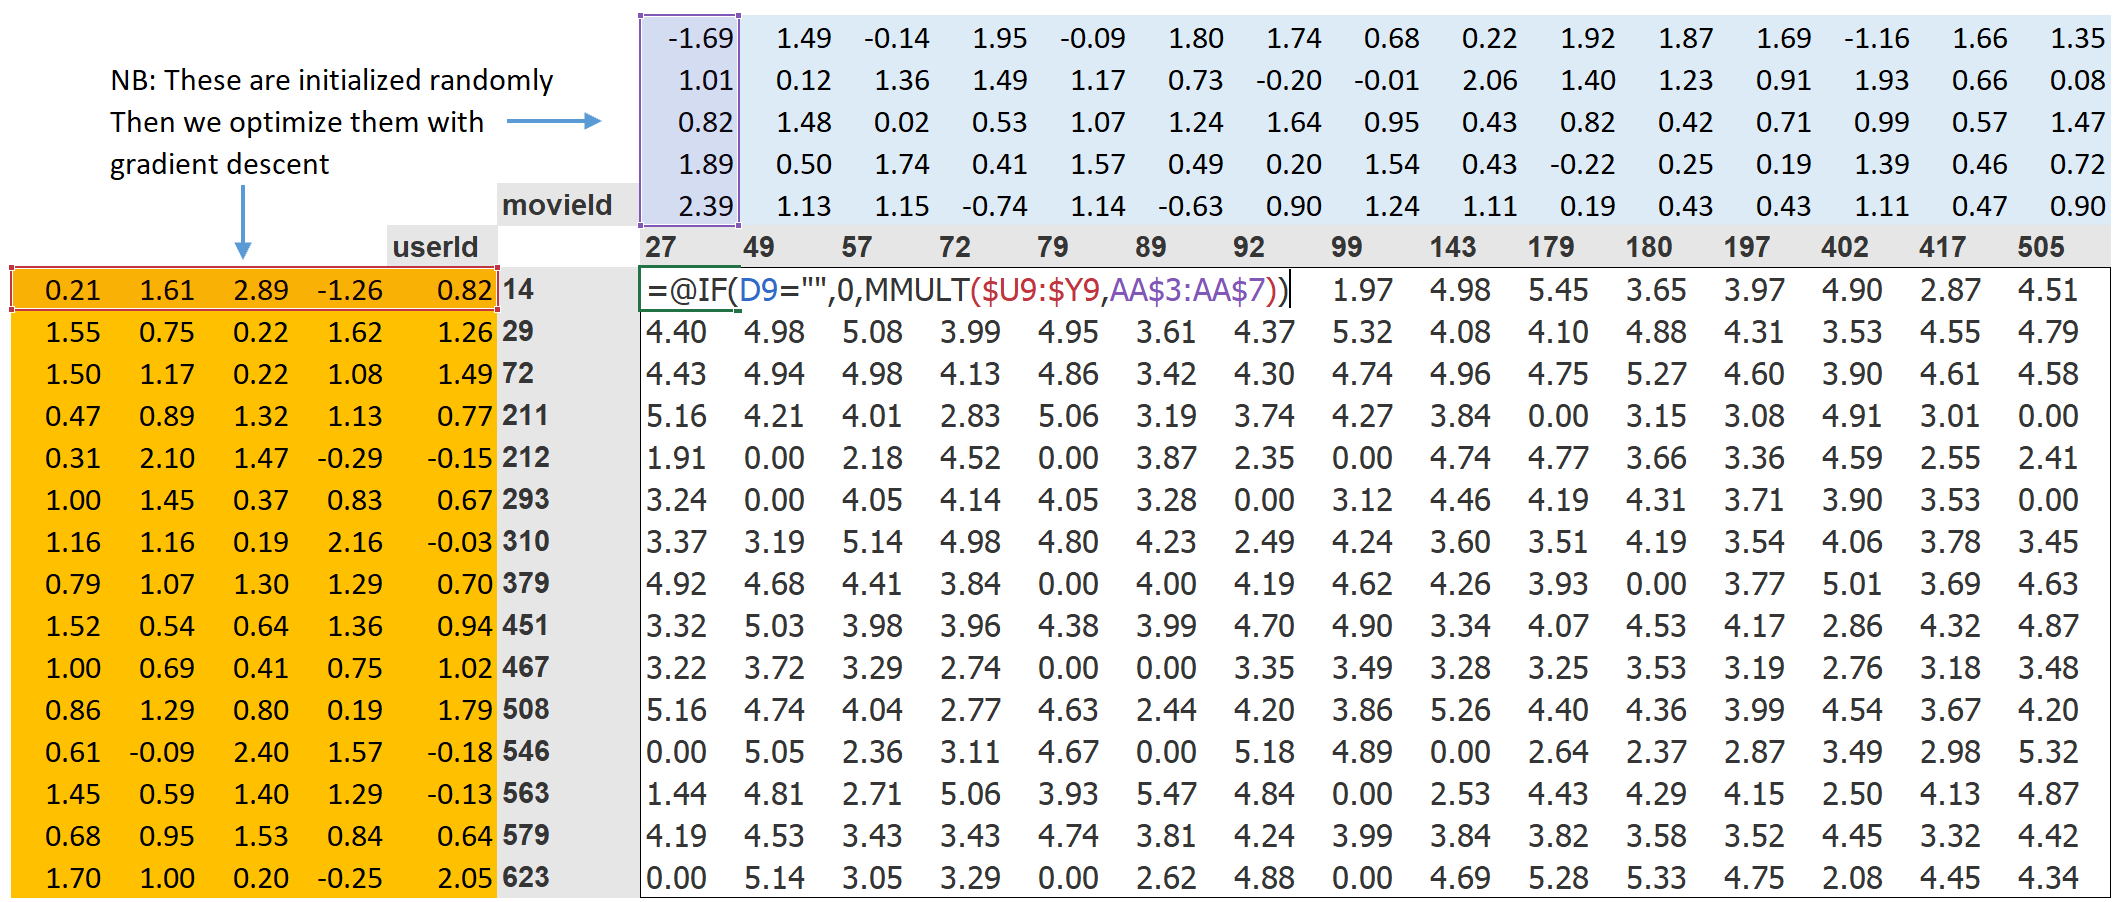

### Creating the DataLoaders

In [8]:
# load the movies
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1',
                     usecols=(0,1), names=('movie','title'), header=None)
movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [9]:
#  merge with the ratings
ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [10]:
# create the dataloaders
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)
dls.show_batch()

,user,title,rating
0,479,Spawn (1997),1
1,805,Tombstone (1993),5
2,291,Braveheart (1995),5
3,7,Daniel Defoe's Robinson Crusoe (1996),4
4,151,"Parent Trap, The (1961)",3
5,757,Romy and Michele's High School Reunion (1997),3
6,337,"Peacemaker, The (1997)",3
7,566,Home Alone (1990),2
8,586,"Rock, The (1996)",4
9,588,Crimson Tide (1995),3


In [11]:
# inspect our classes
dls.classes

{'user': (#944) ['#na#',1,2,3,4,5,6,7,8,9...],
 'title': (#1665) ['#na#',"'Til There Was You (1997)",'1-900 (1994)','101 Dalmatians (1996)','12 Angry Men (1957)','187 (1997)','2 Days in the Valley (1996)','20,000 Leagues Under the Sea (1954)','2001: A Space Odyssey (1968)','3 Ninjas: High Noon At Mega Mountain (1998)'...]}

In [12]:
n_users = len(dls.classes['user'])
n_movies = len(dls.classes['title'])
n_factors = 5

# initialize our random latent factors
user_factors = torch.randn(n_users, n_factors)
movie_factors = torch.randn(n_movies, n_factors)

In [14]:
# inspect our matrices
user_factors.shape, movie_factors.shape

(torch.Size([944, 5]), torch.Size([1665, 5]))

In [29]:
# because our model does not now how to look up and only 
# how to to matrix multiplication and calculate activations 
# we represent the look up as a one hot encoded vector
one_hot_user3 = one_hot(3, n_users).float()
one_hot_user3.shape

torch.Size([944])

In [30]:
# this gives us the same as the lookup
user_factors.t() @ one_hot_user3, user_factors[3]

(tensor([-0.7173, -1.5584,  0.7268,  0.1031, -1.1426]),
 tensor([-0.7173, -1.5584,  0.7268,  0.1031, -1.1426]))

### Build Our Model From Scratch

In [36]:
# create our dot product module
class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
        
    def forward(self, x):
        # x[:,0] -> user ids
        # x[:,1] -> movie ids
        users = self.user_factors(x[:,0]) # returns a batch of users embeddings
        movies = self.movie_factors(x[:,1]) # returns a batch of movie embeddings
        return (users * movies).sum(dim=1) # calculated the loss of these embeddings

In [39]:
# ready with our model ...
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())

In [40]:
# ...we do some learning
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,1.385952,1.274859,00:08
1,1.085273,1.074684,00:08
2,0.955963,0.983505,00:08
3,0.874840,0.894068,00:08
4,0.781911,0.876801,00:08


Until now the model did not know our ratings were between 0 and 5. We add this to our model.

In [43]:
# create our dot product module
class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0, 5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.y_range = y_range
        
    def forward(self, x):
        # x[:,0] -> user ids
        # x[:,1] -> movie ids
        users = self.user_factors(x[:,0]) # returns a batch of users embeddings
        movies = self.movie_factors(x[:,1]) # returns a batch of movie embeddings
        return sigmoid_range((users * movies).sum(dim=1), *self.y_range) # calculated the loss of these embeddings

In [44]:
# retrain our model
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.991548,0.984299,00:08
1,0.867341,0.897816,00:08
2,0.688486,0.858949,00:08
3,0.488761,0.866783,00:08
4,0.379137,0.870622,00:08


The model converges faster and reaches already better performance. But it seems to overfit.

In [15]:
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0, 5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.user_bias = Embedding(n_users, 1)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.movie_bias = Embedding(n_movies, 1)
        self.y_range = y_range
        
    def forward(self, x):
        # x[:,0] -> user ids
        # x[:,1] -> movie ids
        users = self.user_factors(x[:,0]) # returns a batch of users embeddings
        movies = self.movie_factors(x[:,1]) # returns a batch of movie embeddings
        result = (users * movies).sum(dim=1, keepdim=True)
        result += self.user_bias(x[:,0]) + self.movie_bias(x[:,1])
        return sigmoid_range(result, *self.y_range) # calculated the loss of these embeddings

In [48]:
# rinse and repeat
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.948090,0.940276,00:09
1,0.804825,0.846364,00:09
2,0.608487,0.855572,00:09
3,0.398557,0.877461,00:09
4,0.291822,0.883316,00:09


Train loss improves but validation loss is getting bigger. We need some kind of regularization.

### Weight Decay

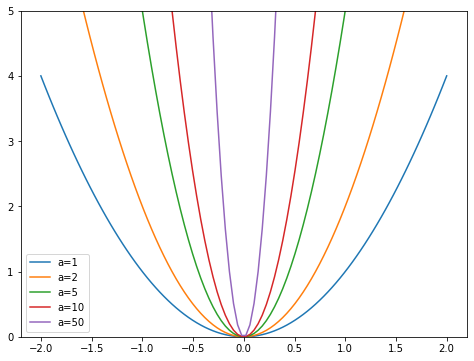

In [3]:
x = np.linspace(-2,2,100)
a_s = [1,2,5,10,50] 
ys = [a * x**2 for a in a_s]
_,ax = plt.subplots(figsize=(8,6))
for a,y in zip(a_s,ys): ax.plot(x,y, label=f'a={a}')
ax.set_ylim([0,5])
ax.legend();

We want our curve be smooth so we add L2 regularization.

 `loss_with_wd = loss + wd * (parameters**2).sum()`

 which after derivation becomes

`parameters.grad += wd * 2 * parameters`


In [17]:
# the same thing in fastai
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=.1)

epoch,train_loss,valid_loss,time
0,0.948811,0.953697,00:08
1,0.871819,0.873512,00:08
2,0.746651,0.829371,00:08
3,0.592478,0.817259,00:08
4,0.496036,0.817178,00:08


That is quiet a lot better!

In [20]:
#  print RMSE
math.sqrt(.817)

0.9038805230781334

### Creating Our Own Embedding Module

In [23]:
# a testmodule
class T(Module):
    def __init__(self): self.a = torch.ones(3)

L(T().parameters())

(#0) []

In [24]:
# for the model to know what the params are we need to use the nn.Parameter method
class T(Module):
    def __init__(self): self.a = nn.Parameter(torch.ones(3))

L(T().parameters())

(#1) [Parameter containing:
tensor([1., 1., 1.], requires_grad=True)]

In [25]:
# of course if we use nn.Linear thats beeing done for us
class T(Module):
    def __init__(self):
        self.a = nn.Linear(1, 3, bias=False)
    
t = T()
L(t.parameters())

(#1) [Parameter containing:
tensor([[0.0888],
        [0.2601],
        [0.3452]], requires_grad=True)]

In [27]:
# we can access our weights directly
type(t.a.weight)

torch.nn.parameter.Parameter

In [32]:
# make a helper function for creating params
def create_params(size):
    return nn.Parameter(torch.zeros(*size).normal_(0, .01))

In [40]:
# rebuild our module without using Embedding
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = create_params([n_users, n_factors])
        self.user_bias = create_params([n_users])
        self.movie_factors = create_params([n_movies, n_factors])
        self.movie_bias = create_params([n_movies])
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors[x[:,0]]
        movies = self.movie_factors[x[:,1]]
        res = (users*movies).sum(dim=1)
        res += self.user_bias[x[:,0]] + self.movie_bias[x[:,1]]
        return sigmoid_range(res, *self.y_range)

In [41]:
# repeat the same from above and compare
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.950751,0.953975,00:09
1,0.832842,0.868882,00:09
2,0.718062,0.828672,00:09
3,0.594030,0.813996,00:09
4,0.477127,0.814992,00:09


As expected the results are the same - just taking one second longer to calculate.

### Interpreting Embeddings and Biases

In [45]:
# get movies that have the lowest biases
movie_bias = learn.model.movie_bias.squeeze()
movie_bias

tensor([-0.0050, -0.1252,  0.0048,  ..., -0.0433,  0.1368,  0.0013],
       device='cuda:0', grad_fn=<SqueezeBackward0>)

In [47]:
# get idxs with lowest values
idxs = movie_bias.argsort()[:10]
[dls.classes['title'][i] for i in idxs]

['Children of the Corn: The Gathering (1996)',
 'Mortal Kombat: Annihilation (1997)',
 'Lawnmower Man 2: Beyond Cyberspace (1996)',
 'Body Parts (1991)',
 'Bio-Dome (1996)',
 'Robocop 3 (1993)',
 'Flintstones, The (1994)',
 'Free Willy 3: The Rescue (1997)',
 'Halloween: The Curse of Michael Myers (1995)',
 'Cable Guy, The (1996)']

In [48]:
# same for movies with highest biases
idxs = movie_bias.argsort(descending=True)[:10]
[dls.classes['title'][i] for i in idxs]

['Titanic (1997)',
 'Star Wars (1977)',
 'L.A. Confidential (1997)',
 'Shawshank Redemption, The (1994)',
 'Good Will Hunting (1997)',
 "Schindler's List (1993)",
 'Usual Suspects, The (1995)',
 'Godfather, The (1972)',
 'Close Shave, A (1995)',
 'Silence of the Lambs, The (1991)']

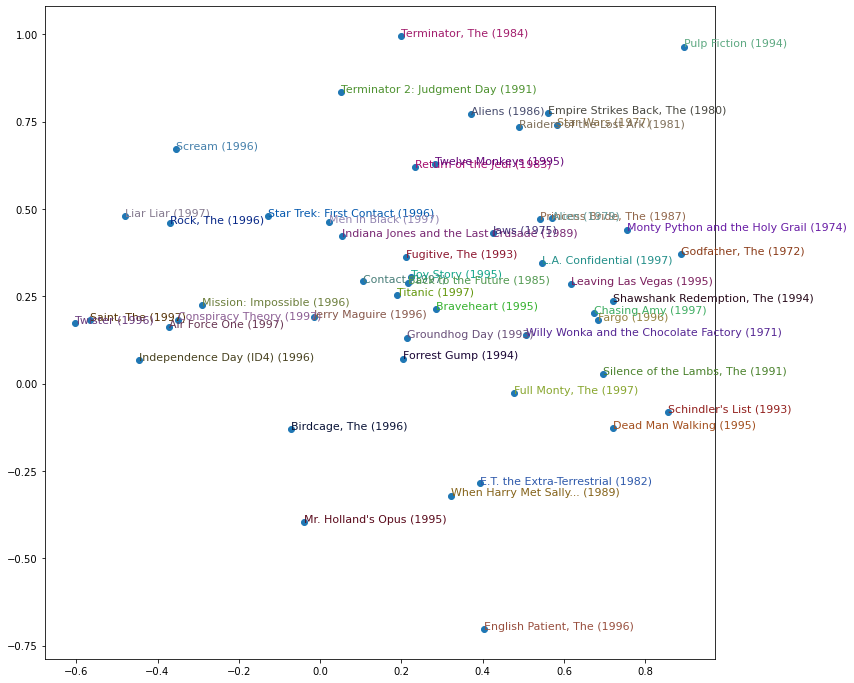

In [55]:
# lets do some pca stuff
g = ratings.groupby('title')['rating'].count()

top_movies = g.sort_values(ascending=False).index.values[:1000]
top_idxs = tensor([learn.dls.classes['title'].o2i[m] for m in top_movies])
movie_w = learn.model.movie_factors[top_idxs].cpu().detach()

# calculate 
movie_pca = movie_w.pca(3)

fac0,fac1,fac2 = movie_pca.t()
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]

plt.figure(figsize=(12,12))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

Why did he not show the third dimension?

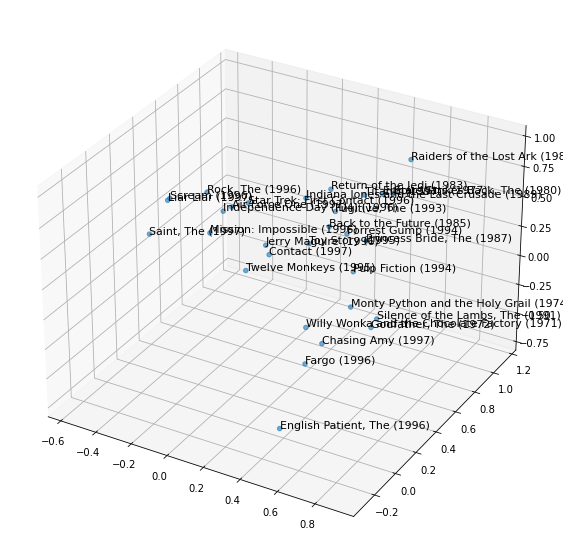

In [72]:
idxs = list(range(30))
X = fac0[idxs]
Y = fac1[idxs]
Z = fac2[idxs]

plt.figure(figsize=(10, 10))
ax = plt.axes(projection ="3d") 
ax.scatter3D(X, Y, Z, alpha=.6)
for i, x, y, z in zip(top_movies[idxs], X, Y, Z):
    ax.text(x,y,z,i, fontsize=11)
plt.show()

In [50]:
ratings

,user,movie,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)
...,...,...,...,...,...
99995,840,1674,4,891211682,Mamma Roma (1962)
99996,655,1640,3,888474646,"Eighth Day, The (1996)"
99997,655,1637,3,888984255,Girls Town (1996)
99998,655,1630,3,887428735,"Silence of the Palace, The (Saimt el Qusur) (1994)"


### Using fastai.collab

In [73]:
# now all that moving fastai modules
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))
learn.fit_one_cycle(5, 5e-3, wd=.1)

epoch,train_loss,valid_loss,time
0,0.948230,0.946374,00:09
1,0.838241,0.874628,00:09
2,0.752837,0.831991,00:10
3,0.598367,0.811825,00:09
4,0.491642,0.812029,00:09


In [74]:
# inspect layers of model
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 50)
  (i_weight): Embedding(1665, 50)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1665, 1)
)

In [75]:
# see the results
movie_bias = learn.model.i_bias.weight.squeeze()
idxs = movie_bias.argsort(descending=True)[:10]
[dls.classes['title'][i] for i in idxs]

['Star Wars (1977)',
 'Titanic (1997)',
 'L.A. Confidential (1997)',
 "Schindler's List (1993)",
 'Shawshank Redemption, The (1994)',
 'Good Will Hunting (1997)',
 'Usual Suspects, The (1995)',
 'Godfather, The (1972)',
 'Close Shave, A (1995)',
 'Silence of the Lambs, The (1991)']

Looks more or less the same.

Lets find the closest movie to a random movie.

In [104]:
# get a random movie
random_idx = np.random.randint(0, len(dls.classes['title']), 1)
dls.classes['title'][random_idx]

(#1) ['Bliss (1997)']

In [105]:
# get movie with highest cosine similarity
idx = dls.classes['title'].o2i[dls.classes['title'][random_idx][0]]
distances = nn.CosineSimilarity(dim=1)(movie_factors, movie_factors[random_idx.item()][None])
idx = distances.argsort(descending=True)[1]
dls.classes['title'][idx]

'Sirens (1994)'

In [106]:
movie_factors[random_idx.item()], movie_factors[idx]

(tensor([ 0.3592, -0.4910,  0.0503, -0.6064,  1.3751]),
 tensor([ 0.8416, -0.7521, -0.2040, -0.9428,  1.8085]))

<img src="attachment:image-2.png" alt="drawing" width="200"/>
<img src="attachment:image-3.png" alt="drawing" width="200"/>

### Deep Learning for Collaborative Filtering

In [13]:
# let fastai suggest some embedding dimensions
embs = get_emb_sz(dls)
embs

[(944, 74), (1665, 102)]

In [22]:
class CollabNN(Module):
    def __init__(self, user_sz, item_sz, y_range=(0,5.5), n_act=100):
        self.user_factors = Embedding(*user_sz)
        self.item_factors = Embedding(*item_sz)
        self.layers = nn.Sequential(
            nn.Linear(user_sz[1]+item_sz[1], n_act),
            nn.ReLU(),
            nn.Linear(n_act, 1))
        self.y_range = y_range
        
    def forward(self, x):
        embs = self.user_factors(x[:,0]),self.item_factors(x[:,1])
        x = self.layers(torch.cat(embs, dim=1))
        return sigmoid_range(x, *self.y_range)

In [23]:
# instantiate our model
model = CollabNN(*embs)
model

CollabNN(
  (user_factors): Embedding(944, 74)
  (item_factors): Embedding(1665, 102)
  (layers): Sequential(
    (0): Linear(in_features=176, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=1, bias=True)
  )
)

In [24]:
# and train our model
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=.01)

epoch,train_loss,valid_loss,time
0,0.937689,0.933895,00:09
1,0.896440,0.899841,00:10
2,0.869208,0.872053,00:09
3,0.778748,0.852959,00:09
4,0.745701,0.855319,00:09


In [25]:
# same can also be achieved by using the fastai learner and use_nn=True
learn = collab_learner(dls, use_nn=True, loss_func=MSELossFlat(), y_range=(0, 5.5), layers=[100, 50])
learn.model

EmbeddingNN(
  (embeds): ModuleList(
    (0): Embedding(944, 74)
    (1): Embedding(1665, 102)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): BatchNorm1d(176, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=176, out_features=100, bias=False)
      (2): ReLU(inplace=True)
    )
    (1): LinBnDrop(
      (0): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=100, out_features=50, bias=False)
      (2): ReLU(inplace=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=50, out_features=1, bias=True)
    )
    (3): SigmoidRange(low=0, high=5.5)
  )
)

Ah, as it seems there is a little more to it.

In [27]:
# try that
learn.fit_one_cycle(5, 5e-3, wd=.01)

epoch,train_loss,valid_loss,time
0,0.832540,0.880413,00:11
1,0.874504,0.865321,00:11
2,0.790609,0.842569,00:11
3,0.724628,0.844939,00:11
4,0.678808,0.854708,00:11


In [29]:
# and with the lr from the book
learn = collab_learner(dls, use_nn=True, loss_func=MSELossFlat(), y_range=(0, 5.5), layers=[100, 50])
learn.fit_one_cycle(5, 5e-3, wd=.1)

epoch,train_loss,valid_loss,time
0,0.994531,0.968651,00:11
1,0.940233,0.902297,00:11
2,0.860937,0.875886,00:11
3,0.819187,0.849974,00:11
4,0.764697,0.849842,00:11


Altough the performance is a little worse we could now directly include other movie or user information.